In [328]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [329]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [342]:
def into_cell(data, err, info_data, file, save_diagram, position, noiseless_data, wave = data_1sig[:, 0]):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
        
    b_scale = record["b_scale"]
    som = record["som"]
    dim = record["dim"]
    
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)

    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Topological error: {record["topo_err"]}")
    print(f"Quantization error: {record["quan_err"]}")
    
    if True:
        magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
        magnitude_map.fill(np.nan)
        z_map = np.zeros(dim ** 2).reshape(dim, dim)
        z_map.fill(np.nan)
        labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1), np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
    
        for i in labels_map.keys():
            if i == position:
                properties = np.array(list(labels_map[position].keys()))
                
                plt.close()
                plt.figure(figsize = (30, 10))
                plt.subplot(121)
                plt.hist(properties[:,0], bins = 15, rwidth = 0.95)
                plt.xlabel("HSC i-band Magitude")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,0]), 5)} Median: {round(np.median(properties[:, 0]), 5)} Std: {round(np.std(properties[:, 0], ddof = 1) / (1 + np.mean(properties[:, 0])), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,0]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,0]), c = "r", label = "median")
                plt.legend()
                
                plt.subplot(122)
                plt.hist(properties[:,1], bins = 15, rwidth = 0.95)
                plt.xlabel("Spectroscopic Redshift")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,1]), 5)} Median: {round(np.median(properties[:, 1]), 5)} Std: {round(np.std(properties[:,1 ], ddof = 1) / (1 + np.mean(properties[:, 1])), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,1]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,1]), c = "r", label = "nedian")
                plt.legend()
                if save_diagram != False:
                    plt.savefig("D:/SPHEREx_SOM/record/5th_exploration/in_cell/" + file.split("/")[-1].replace(".pkl", "") + "_" + str(position) + "_" + "hist.jpg", bbox_inches = "tight")
                plt.show()

                plt.close()
                plt.figure(figsize = (30, 20))
                plt.subplot(211)
                for i in noiseless_data[properties[:, 2].astype(np.int32)]:
                    plt.plot(wave, i, marker = ".", alpha = 0.6)
                plt.plot(wave, np.mean(noiseless_data[properties[:, 2].astype(np.int32)], axis = 0), marker = ".", lw = 4, c = "k", label = "Mean", ls = "--")
                plt.xlabel("Wavelength (micrometer)")
                plt.ylabel("Arbitrary arcsinh magnitude")
                plt.title("Noiseless data")
                plt.legend()

                weights = som.get_weights()

                plt.subplot(212)
                for i in proc_data[properties[:, 2].astype(np.int32)]:
                    plt.plot(wave, i, marker = ".", alpha = 0.3)
                plt.plot(wave, np.mean(proc_data[properties[:, 2].astype(np.int32)], axis = 0), marker = ".", lw = 3, c = "k", label = "Mean", ls = "--")
                plt.plot(wave, weights[position[0], position[1]], marker = ".", lw = 3, c = "r", label = "Weight", ls = "--")
                plt.xlabel("Wavelength (micrometer)")
                plt.ylabel("Arbitrary arcsinh magnitude")
                plt.title("Noisy data")
                plt.legend()
                if save_diagram != False:
                    plt.savefig("D:/SPHEREx_SOM/record/5th_exploration/in_cell/" + file.split("/")[-1].replace(".pkl", "") + "_" + str(position) + "_" + "photo.jpg", bbox_inches = "tight")
                plt.show()

        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]
        for i in labels_map.keys():
            if i == position:
                properties = np.array(list(labels_map[position].keys()))
                
                plt.close()
                plt.figure(figsize = (30, 10))
                plt.subplot(121)
                plt.hist(properties[:,0], bins = 15, rwidth = 0.95)
                plt.xlabel("HSC i-band Magitude")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,0]), 5)} Median: {round(np.median(properties[:, 0]), 5)} Std: {round(np.std(properties[:, 0], ddof = 1) / (1 + np.mean(properties[:, 0])), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,0]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,0]), c = "r", label = "median")
                plt.legend()
                
                plt.subplot(122)
                plt.hist(properties[:,1], bins = 15, rwidth = 0.95)
                plt.xlabel("Spectroscopic Redshift")
                plt.ylabel("# of Galaxies")
                plt.title(f"Mean: {round(np.mean(properties[:,1]), 5)} Median: {round(np.median(properties[:, 1]), 5)} Std: {round(np.std(properties[:,1 ], ddof = 1) / (1 + np.mean(properties[:, 1])), 5)} Total: {len(properties[:,0])}")
                plt.axvline(x = np.mean(properties[:,1]), c = "k", label = "mean")
                plt.axvline(x = np.median(properties[:,1]), c = "r", label = "nedian")
                plt.legend()
                if save_diagram != False:
                    plt.savefig("D:/SPHEREx_SOM/record/5th_exploration/in_cell/" + file.split("/")[-1].replace(".pkl", "") + "_" + str(position) + "_" + "hist.jpg", bbox_inches = "tight")
                plt.show()

                plt.close()
                plt.figure(figsize = (30, 20))
                plt.subplot(211)
                for i in noiseless_data[properties[:, 2].astype(np.int32)]:
                    plt.plot(wave, i, marker = ".", alpha = 0.6)
                plt.plot(wave, np.mean(noiseless_data[properties[:, 2].astype(np.int32)], axis = 0), marker = ".", lw = 4, c = "k", label = "Mean", ls = "--")
                plt.xlabel("Wavelength (micrometer)")
                plt.ylabel("Arbitrary arcsinh magnitude")
                plt.title("Noiseless data")
                plt.legend()

                plt.subplot(212)
                for i in proc_data[properties[:, 2].astype(np.int32)]:
                    plt.plot(wave, i, marker = ".", alpha = 0.3)
                plt.plot(wave, np.mean(proc_data[properties[:, 2].astype(np.int32)], axis = 0), marker = ".", lw = 3, c = "k", label = "Mean", ls = "--")
                plt.plot(wave, weights[position[0], position[1]], marker = ".", lw = 3, c = "r", label = "Weight", ls = "--")
                plt.xlabel("Wavelength (micrometer)")
                plt.ylabel("Arbitrary arcsinh magnitude")
                plt.title("Noisy data")
                plt.legend()
                if save_diagram != False:
                    plt.savefig("D:/SPHEREx_SOM/record/5th_exploration/in_cell/" + file.split("/")[-1].replace(".pkl", "") + "_" + str(position) + "_" + "photo.jpg", bbox_inches = "tight")
                plt.show()

In [343]:
def std_map(data, err, info_data, file, save_diagram):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    dim = record["dim"]
    som = record["som"]
    b_scale = record["b_scale"]
        
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)

    mag_std = np.zeros(dim ** 2).reshape(dim, dim)
    mag_std.fill(np.nan)
    z_std = np.zeros(dim ** 2).reshape(dim, dim)
    z_std.fill(np.nan)

    mag_std_gal = np.array([])
    z_std_gal = np.array([])
    
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Topological error: {record["topo_err"]}")
    print(f"Quantization error: {record["quan_err"]}")

    if "prop_map" not in record:
        labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1), np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
    
        for i in labels_map.keys():
            properties = np.array(list(labels_map[i].keys()))
            means = np.mean(properties, axis = 0)
            stds = np.std(properties, axis = 0, ddof = 1)
            mag_std[int(list(i)[0]), int(list(i)[1])] = stds[0]
            z_std[int(list(i)[0]), int(list(i)[1])] = stds[1] / (means[1] + 1)
            mag_std_gal = np.concatenate((mag_std_gal, np.tile(np.array([stds[0]]), properties.shape[0])))
            z_std_gal = np.concatenate((z_std_gal, np.tile(np.array([stds[1]]), properties.shape[0])))

        print(np.nanmean(z_std_gal))

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (30, 20))
        plt.subplot(221)
        plt.pcolor(mag_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("HSC i-band std")

        plt.subplot(222)
        plt.pcolor(z_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("Redshift std")

        plt.subplot(223)
        plt.hist(mag_std_gal, bins = 20)
        plt.title("HSC i-band Std Tomography")
        
        plt.subplot(224)
        plt.hist(z_std_gal, bins = 20)
        plt.title("Redshift Std Tomography")
        
        plt.show()

        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]
        
        for i in labels_map.keys():
            properties = np.array(list(labels_map[i].keys()))
            means = np.mean(properties, axis = 0)
            stds = np.std(properties, axis = 0, ddof = 1)
            mag_std[int(list(i)[0]), int(list(i)[1])] = stds[0]
            z_std[int(list(i)[0]), int(list(i)[1])] = stds[1] / (means[1] + 1)
            mag_std_gal = np.concatenate((mag_std_gal, np.tile(np.array([stds[0]]), properties.shape[0])))
            z_std_gal = np.concatenate((z_std_gal, np.tile(np.array([stds[1]]), properties.shape[0])))

        print(f"Mean redshift std: {np.nanmean(z_std_gal)}")
        print(f"std < 0.003: {z_std_gal[z_std_gal < 0.003].shape[0]}")
        print(f"std < 0.01: {z_std_gal[z_std_gal < 0.01].shape[0]}")
        print(f"std < 0.03: {z_std_gal[z_std_gal < 0.03].shape[0]}")
        print(f"std < 0.1: {z_std_gal[z_std_gal < 0.1].shape[0]}")
        print(f"std < 0.2: {z_std_gal[z_std_gal < 0.2].shape[0]}")

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (30, 20))
        plt.subplot(221)
        plt.pcolor(mag_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("HSC i-band std")

        plt.subplot(222)
        plt.pcolor(z_std.T, cmap='YlGn') 
        plt.colorbar()
        plt.title("Redshift std")

        plt.subplot(223)
        plt.hist(mag_std_gal, bins = 50)
        plt.title("HSC i-band Std Tomography")
        
        plt.subplot(224)
        plt.hist(z_std_gal, bins = 50)
        plt.title("Redshift Std Tomography")
        
        plt.show()

In [344]:
data = pd.DataFrame(data_deep[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
err = data_deep[0, 1::2]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_46748\3844147592.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]


Topological error: 0.605194892699525
Quantization error: 1.5553599047709565
Topological error: 0.605194892699525
Quantization error: 1.555359904770957


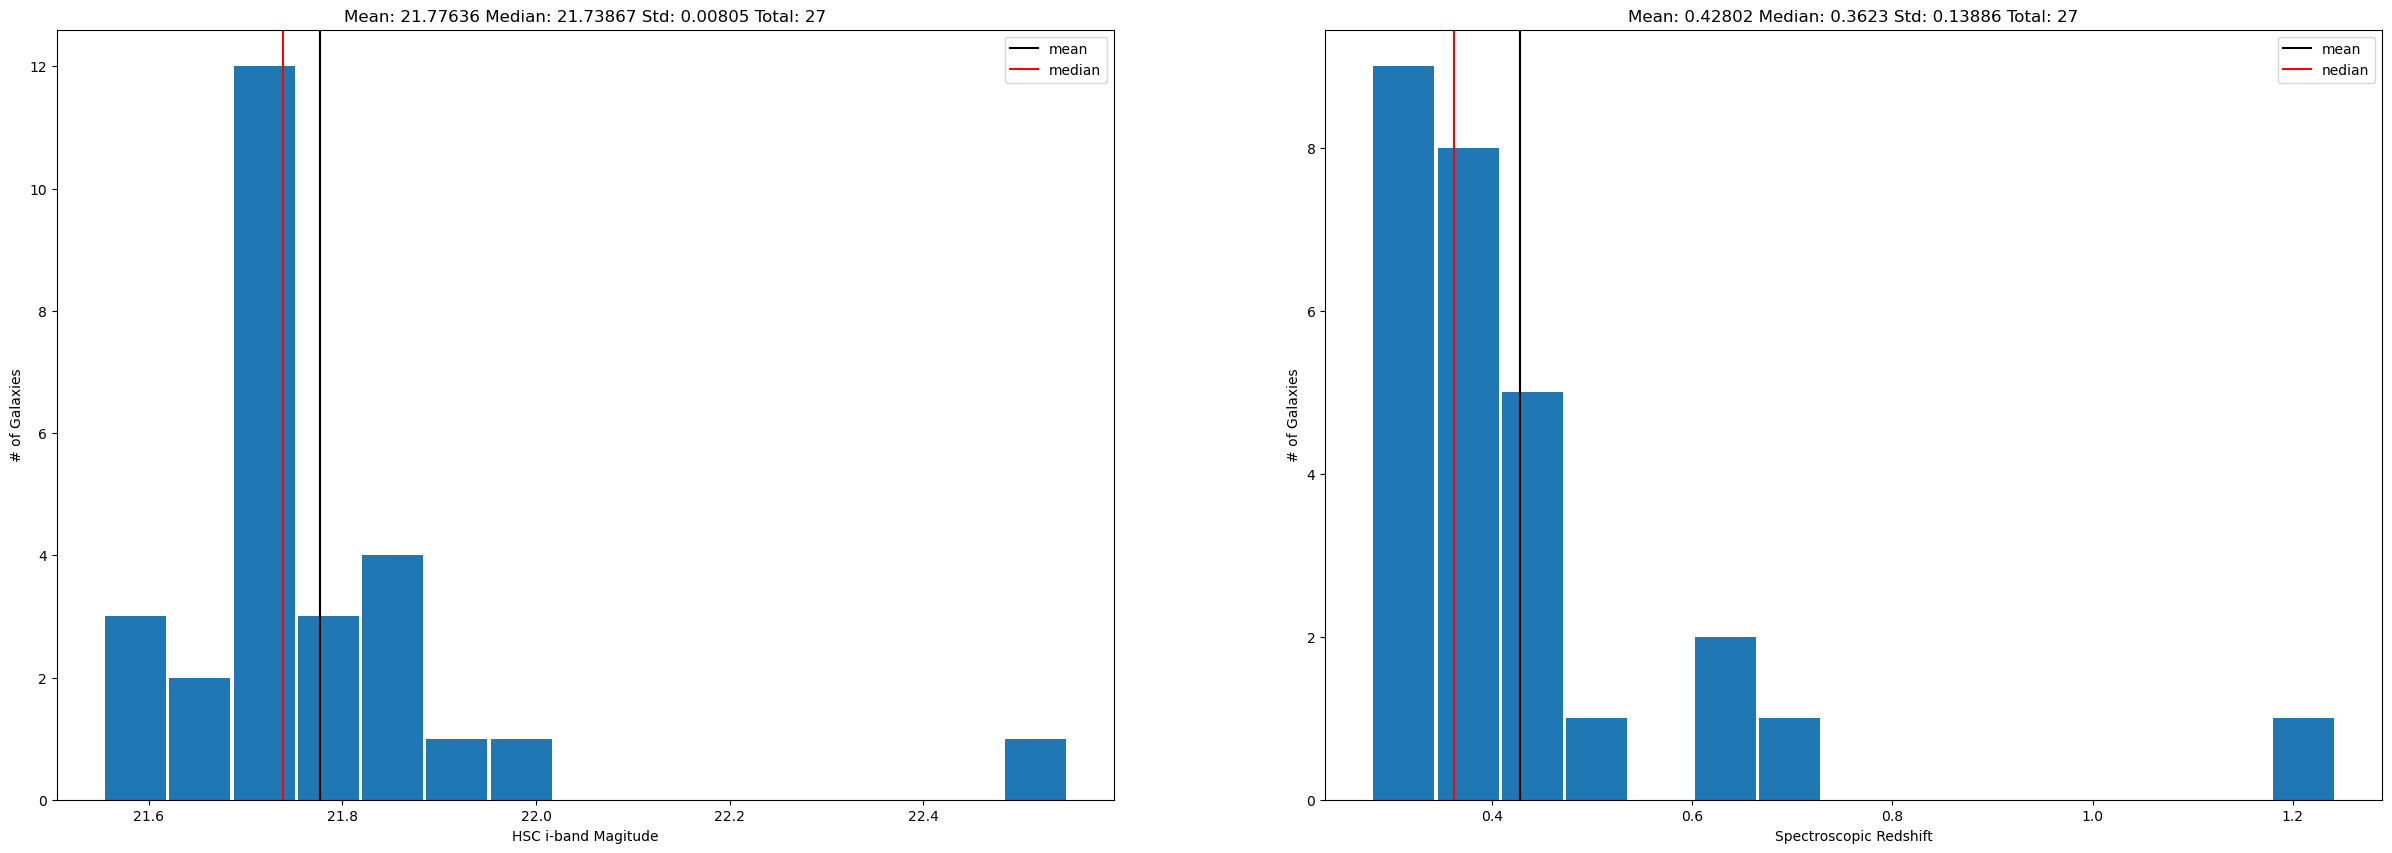

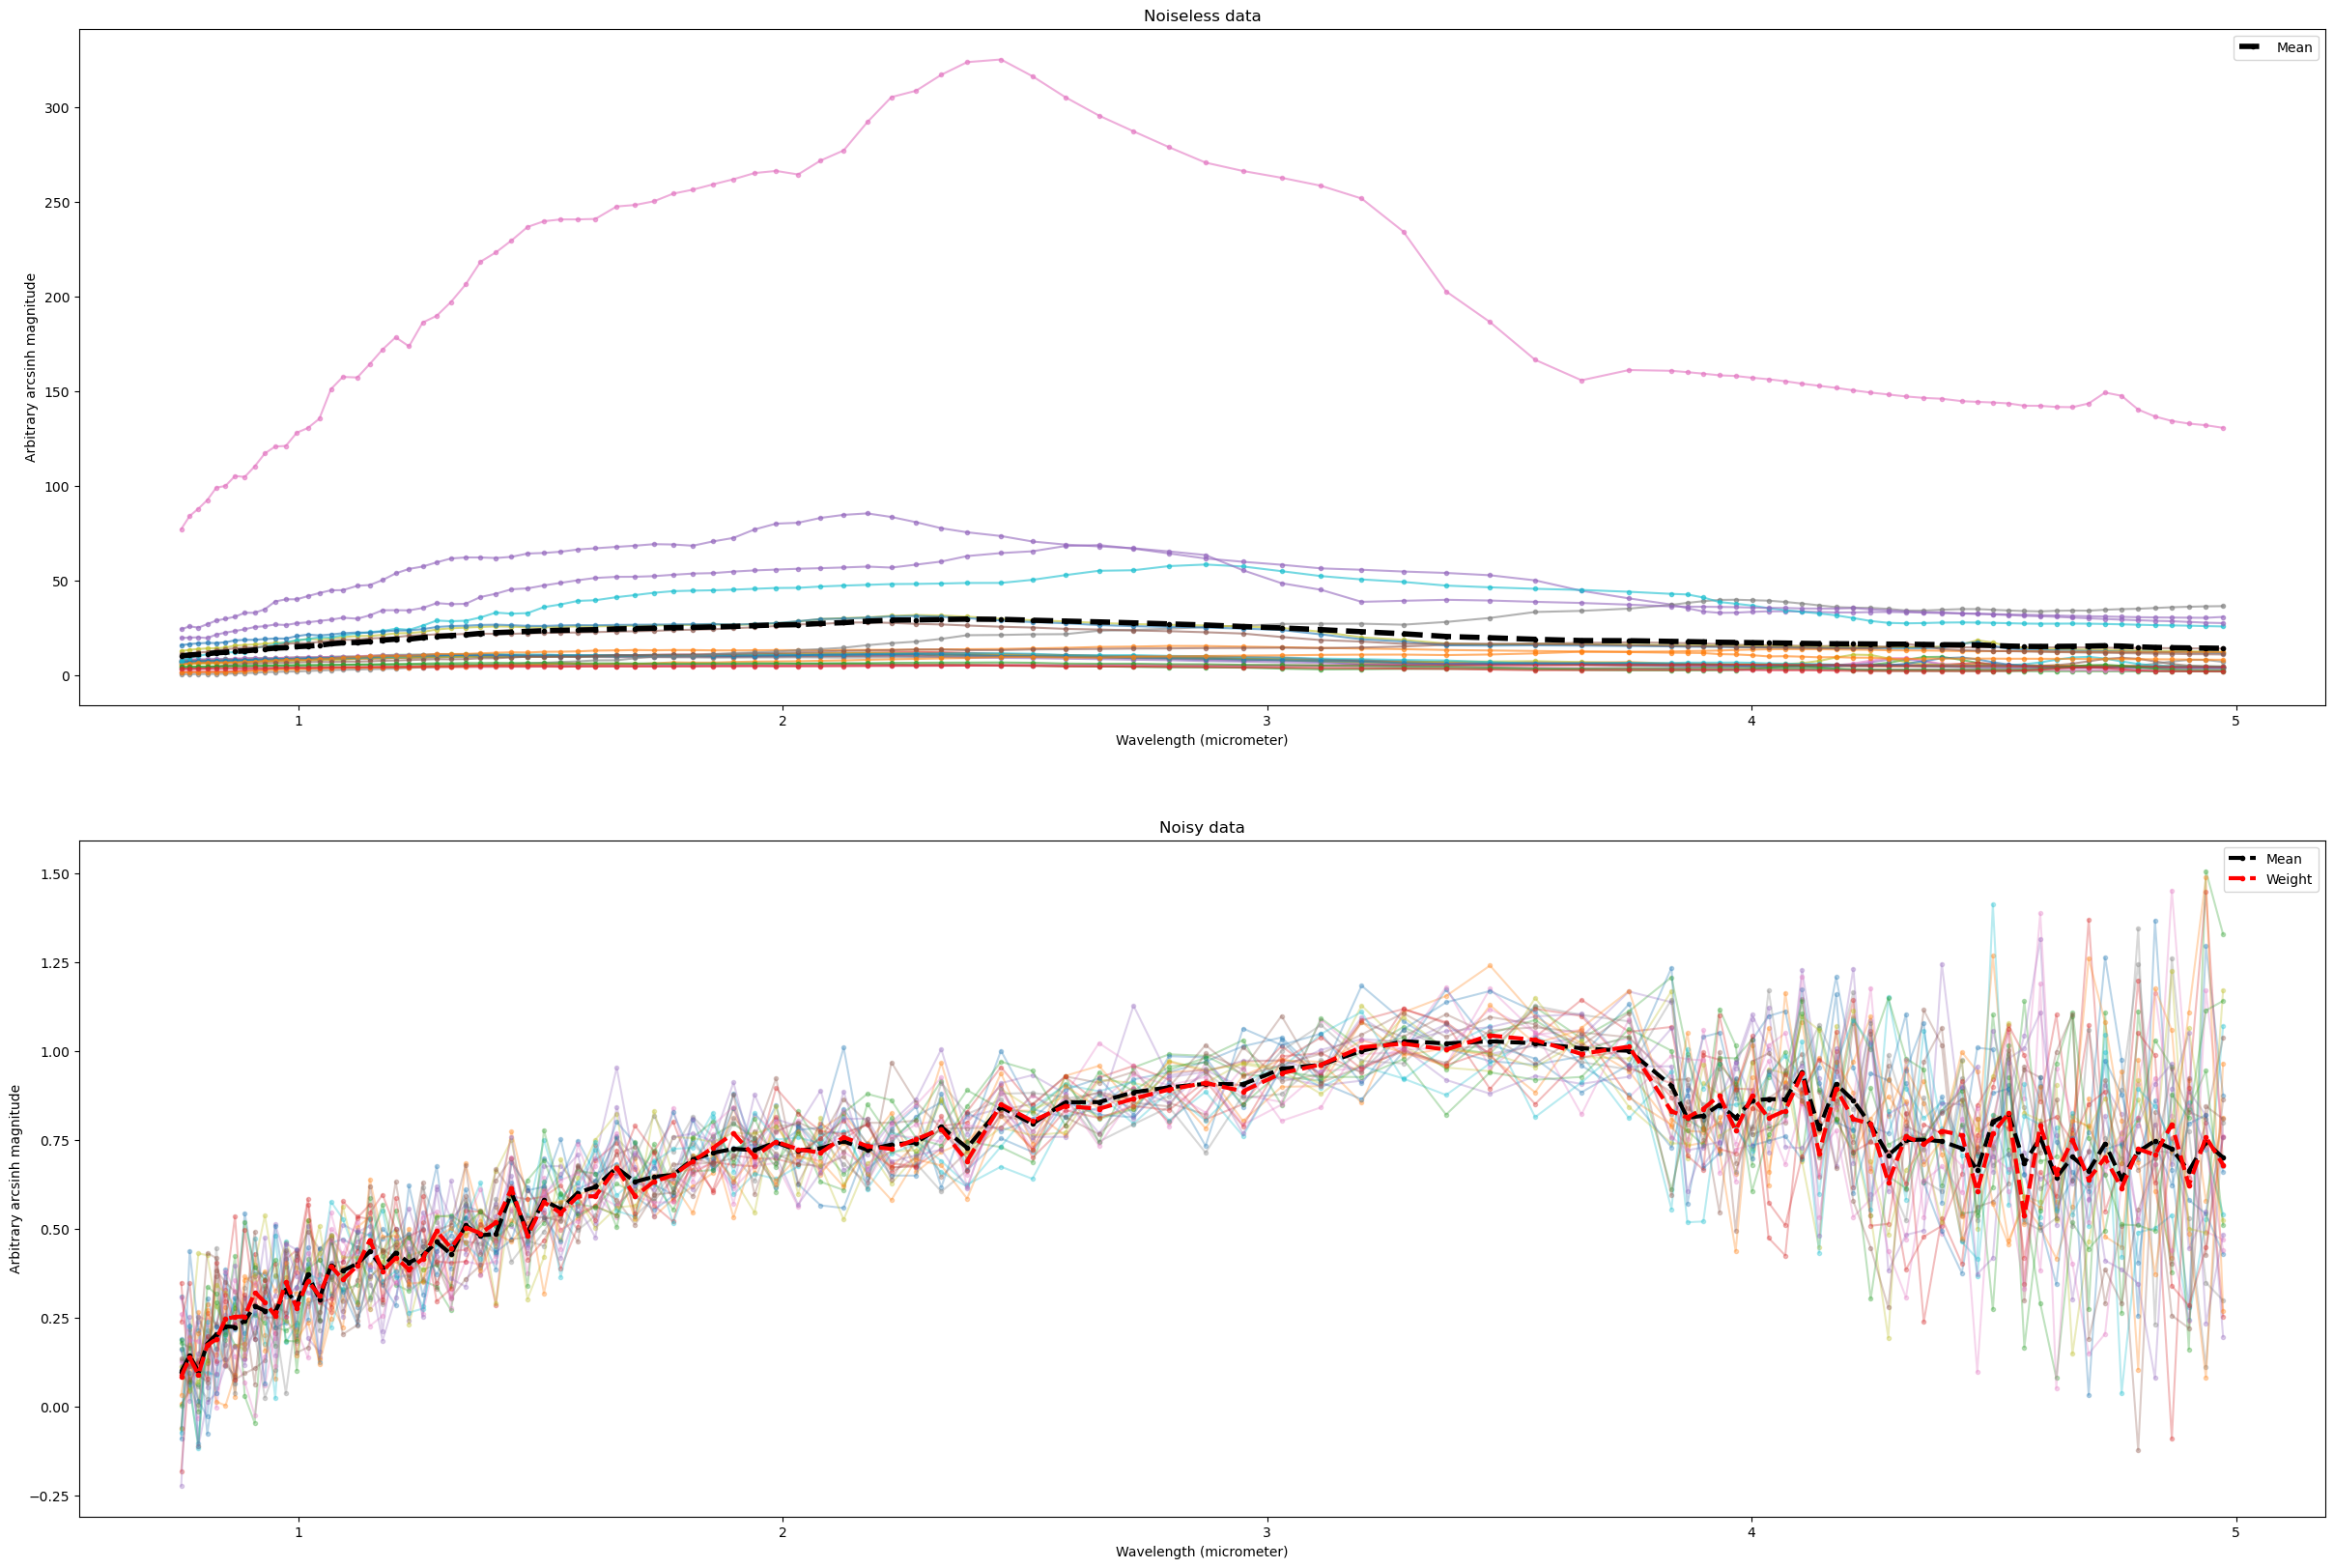

In [345]:
into_cell(data = data, err = err, info_data = info, position = (2, 23), file = "D:/SPHEREx_SOM/record/5th_exploration/SOM/chi2_lup_deep_50_0.9_0.4_10_3.pkl", save_diagram = True, noiseless_data = data_noiseless)

In [ ]:
std_map(data = data, err = err, info_data = info, file = "D:/SPHEREx_SOM/record/5th_exploration/SOM/chi2_lup_deep_50_0.7_0.8_10_4.pkl", save_diagram = True)